### GAN vanilla experiment

In [ ]:
import torch
import torchvision


from functools import partial
from torch.optim.lr_scheduler import LambdaLR
import os
import pickle
from collections import OrderedDict
from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

### 1. Convolutional Neural Network

At first one can define convolutional neural network, whose filters are used for training. This neural network should classify images of CIFAR10.

This network is composed of:


1.   1st layer: 384 filters, 7x7
2.   2nd layer: 32768 filters, 5x5
3.   3rd layer: 65536  filters, 5x5



In [ ]:
class SimpleConvNet(torch.nn.Module):
    def __new__(cls, n_classes=10):
        return torch.nn.Sequential(OrderedDict([
            ('layer_1', torch.nn.Conv2d(3, 128, 7, bias=False)),
            ('layer_1_bn', torch.nn.BatchNorm2d(128)),
            ('layer_1_relu', torch.nn.LeakyReLU()),
            ('layer_1_mp', torch.nn.MaxPool2d(2)),
            # ('layer_1_drop', torch.nn.Dropout(0.3)),

            ('layer_2', torch.nn.Conv2d(128, 256, 5, bias=False)),
            ('layer_2_bn', torch.nn.BatchNorm2d(256)),
            # ('layer_2_drop', torch.nn.Dropout(0.3)),
            ('layer_2_relu', torch.nn.LeakyReLU()),

            ('layer_3', torch.nn.Conv2d(256, 256, 5, bias=False)),
            ('layer_3_bn', torch.nn.BatchNorm2d(256)),
            # ('layer_3_drop', torch.nn.Dropout(0.3)),
            ('layer_3_relu', torch.nn.LeakyReLU()),

            ('flatten', torch.nn.Flatten()),

            ('layer_4', torch.nn.Linear(256 * 5 * 5, 512)),
            # ('layer_4_drop', torch.nn.Dropout(0.3)),
            ('layer_4_relu', torch.nn.ReLU()),

            ('layer_5', torch.nn.Linear(512, n_classes)),
        ]))

In [ ]:
model = SimpleConvNet(n_classes=10).cuda()

### 2. Infinite Sampler for filters of CNN for each layer

The following class constitutes infinite sampler for filters of each layer

In [ ]:
class LiveConv2dSliceInfiniteSampler:
  
  def __init__(self, module, batch_size=None):
    assert isinstance(module, torch.nn.Conv2d)
    self.module = module
    self.batch_size = batch_size
    self.shape = self.module.weight.shape[-2:]
    # self.shape is equal to shape of filter in a layer
    # for instance, self.shape = torch.tensor([3,3])
    # if kernel_size of the layer equals 3

  def __str__(self):
    return f"module is {self.module} and batch_size is {self.batch_size}"
  
  # namely it is used for object of class
  def __repr__(self):
    text = f" module = {self.module} , batch_size = {self.batch_size}"
    return type(self).__name__ + "(" + text + ")" 

  def __len__(self):
    return self.module.weight.shape[:-2].numel()
  
  def __iter__(self):
    n_batches = (self.__len__() + self.batch_size - 1)//(self.batch_size)
    while True:
      sequence = torch.randperm(self.__len__(), device = self.module.weight.device) # the second parameter is cuda
      # before for to avoid intersections of batches
      for i in range(n_batches):
        view = self.module.weight.view(-1, *self.shape)
        yield view[sequence[i*self.batch_size : (i+1)*self.batch_size]] 

### 3. Source Kernel Distriution

We trained 11 models of CNN for classification of images of CIFAR100 and obtained SKD for each layer of the CNN. let me show up at all these filters

Download filters from files of google drive

1.   Filters_1_layer_1
2.   Filters_1_layer_2
3.   Filters_1_layer_3
4.   Filters_2_layer_1
5.   Filters_2_layer_2
6.   Filters_2_layer_3

In [ ]:
path = os.path.join('drive', 'My Drive','filters', 'Filters_2_layer_1.pkl')
with open(path, 'rb') as handle:
    tensor_ = pickle.load(handle)

In [ ]:
conv1_tensor_ = torch.cat([tensor_,tensor])
#conv2_tensor_ = torch.cat([tensor_,tensor])
#conv3_tensor_= torch.cat([tensor_,tensor])



1.   SKD 1st layer: 3072 filters, 7x7
2.   SKD 2nd layer: 262 144 filters, 5x5
3.   SKD 3rd layer: 524 288 filters, 5x5



Let me plot graphs that deal with norms of filters through all layers.

In [ ]:
filters_1 = conv1_tensor_.reshape(8*128*3,7,7)
filters_2 = conv2_tensor_.reshape(8*256*128,5,5)
filters_3 = conv3_tensor_.reshape(8*256*256,5,5)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

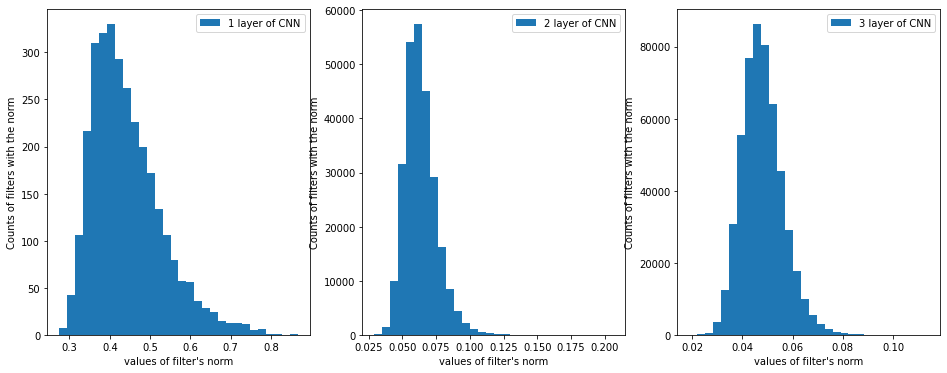

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax = ax.flatten()
for idx in range(3):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();

In [ ]:
SKD_convolutional_weights = {name: filters for name, filters in zip( ['layer_1','layer_2','layer_3'],\
                                                             [filters_1,filters_2,filters_3])}

### 4. Vanilla Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __new__(cls, input_dim, hidden):
        assert isinstance(hidden, list)

        model = [torch.nn.Flatten()]
        hidden_layers = [input_dim] + hidden + [1]
        for in_features, out_features in zip(hidden_layers, hidden_layers[1:]):
            model.extend([
                torch.nn.Linear(in_features, out_features),
                torch.nn.ReLU()
            ])
        model.pop()

        return torch.nn.Sequential(*model)

Let's move on the following part of the experiment that deals with defining loss function of discriminator $\mathbb{D}$.

As we have already said our discriminator returns one logit, because it is inherited from MLP class. However, there should be probability of logit in loss of discriminator like as follow:

The loss of a discriminator
$$
\mathcal{L}_{\mathrm{dis}}(\theta)
    = - \tfrac12 \mathbb{E}_{\mathcal{L}_{\mathrm{teacher}}}
        \log \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{teacher}}))
    - \tfrac12 \mathbb{E}_{ \mathcal{L}_{\mathrm{student}}}
        \log (1 - \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{student}})))
\,. $$

However, this expression is not stable for high($\to$ $\infty$) and low ($\to$ -$\infty$) values for the reason exponent in denominator of sigmoid.

The sigmoid function is:
$$
\sigma(p)
    = \frac1{1 + e^{-p}}
    \,, \sigma(-p) = 1-\sigma(p)$$



However, we have
$$
\ell(y, p)
    = - y \log \sigma(p) - (1-y) \log (1 - \sigma(p))
    %% p > 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^{-p}) + p - y p
    %% p < 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^p) - y p
    = \log (1+e^{-\lvert p\rvert}) - y p + \max \( p, 0 \)
\ $$
which is implemented in `torch.nn.BCEWithLogitsLoss`, so we don't have to do this ourselves.



In [ ]:
def dis_loss(discriminator,  real, fake, ell=torch.nn.BCEWithLogitsLoss()):
    out_real = discriminator(real)
    out_fake = discriminator(fake.detach())

    loss_real = ell(out_real, torch.full_like(out_real, 0.9))
    loss_fake = ell(out_fake, torch.full_like(out_fake, 0.))
    return loss_real * 0.5 + loss_fake * 0.5

In [ ]:
def gen_loss_dis(discriminator, *, fake, ell=None):
    return -discriminator(fake).mean()

In [ ]:
def gen_loss_task(model, *, input, target, criterion=torch.nn.CrossEntropyLoss()):
    return criterion(model(input), target)

#### 4.1 Checking of Discriminator

In [ ]:
def make_step(diss_loss_fn, discriminator, discriminator_optimizer, real, fake):
  discriminator_optimizer.zero_grad()
  discriminator_loss = diss_loss_fn(discriminator, real, fake)
  protect(discriminator_loss).backward()
  discriminator_optimizer.step()
  return discriminator_loss

In [ ]:
def train_epoch_discriminator(discriminator,
                              loader_skd,
                              diss_loss_fn,
                              discriminator_optimizer,
                              ker_iter_gen,
                              current_steps,
                              critic_steps):
  
  discriminator.requires_grad_(True)
  probs_true, probs_fake, discrim_loss = list(),list(),list()

  for batch_skd in loader_skd:
    current_steps += 1
    batch_fake = next(ker_iter_gen).detach()

    if batch_fake.shape[0] > batch_skd.shape[0]:
      batch_fake = batch_fake[:batch_skd.shape[0]]
    elif batch_fake.shape[0] < batch_skd.shape[0]:
      batch_skd = batch_skd[:batch_fake.shape[0]]

    dis_loss = make_step(diss_loss_fn, discriminator, discriminator_optimizer, batch_skd, batch_fake )

    probs_true.append(discriminator(batch_skd).detach().sigmoid().mean().cpu().numpy())
    probs_fake.append(discriminator(batch_fake).detach().sigmoid().mean().cpu().numpy())
    discrim_loss.append(dis_loss.detach().cpu().numpy())

    if current_steps == critic_steps:
      break

  return {"discriminator_loss": discrim_loss,
          "probabilities_SKD" : probs_true,
          "probabilities_fitness": probs_fake},current_steps

In [ ]:
def train_discriminator(num_epochs,
                        critic_steps,
                        discriminator,
                        loader_skd,
                        diss_loss_fn,
                        discriminator_optimizer,
                        ker_iter_gen):

  result_dict = { "discriminator_loss": [],"probabilities_SKD":[],"probabilities_fitness":[] }
  current_steps = 0
  for epoch in tqdm_notebook(range(num_epochs)):
    loss_prob_dict,current_steps = train_epoch_discriminator(discriminator,loader_skd,diss_loss_fn,
                                               discriminator_optimizer,ker_iter_gen,current_steps,critic_steps)
     
    
    for name in result_dict.keys():
      result_dict[name].extend(loss_prob_dict[name])

    if current_steps >= critic_steps:
      break

  return result_dict

In [ ]:
# define intermediate layers of Discriminator
HIDDEN_DISCR = [100, 100]
LR_1 = 1e-3
LR_2 = 1e-3
LR_3 = 1e-3

LR_dict = {name: lr for name,lr in zip(["layer_1","layer_2","layer_3"] ,[LR_1,LR_2,LR_3])}

# Dictionary of discriminators
discriminators = torch.nn.ModuleDict({
    name: Discriminator(module.weight.shape[-2:].numel(), HIDDEN_DISCR)
    for name, module in model.named_modules()
    if isinstance(module, torch.nn.Conv2d)
}).cuda()

discriminators_optimizers = {name: torch.optim.Adam(model.parameters(),lr=LR_dict[name])
                  for name, model in discriminators.items()}

In [ ]:
NUM_EPOCHS = 100
DIS_LOSS_FN = dis_loss
CRITIC_STEPS = 2000

discrim_check_dict = {name: train_discriminator(NUM_EPOCHS, CRITIC_STEPS, discriminators[name], train_loaders_SKD[name], DIS_LOSS_FN,
                                                discriminators_optimizers[name], ker_iter_gen) 
                      for  name, ker_iter_gen in ker_iters_gen.items()}

In [ ]:
def plot_loss_probs(discrim_check_dict):
  fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(18,10))
  for name,idx in zip(discrim_check_dict.keys(),[1,3,5]):
    plt.subplot(3,2,idx)
    plt.title(str((idx+2.5)//2.5) + " layer")
    plt.plot(discrim_check_dict[name]['discriminator_loss'],color='olive',label='loss of '+ str((idx+2.5)//2.5) + " discriminator")
    plt.legend()

    plt.subplot(3,2,idx+1)
    plt.title(str((idx+2.5)//2.5) + " layer")
    plt.plot(discrim_check_dict[name]['probabilities_SKD'],color='maroon',label='probabilities of SKD')
    plt.plot(discrim_check_dict[name]['probabilities_fitness'],color='yellowgreen',label='probabilities of fitness')
    plt.legend()
  plt.show()


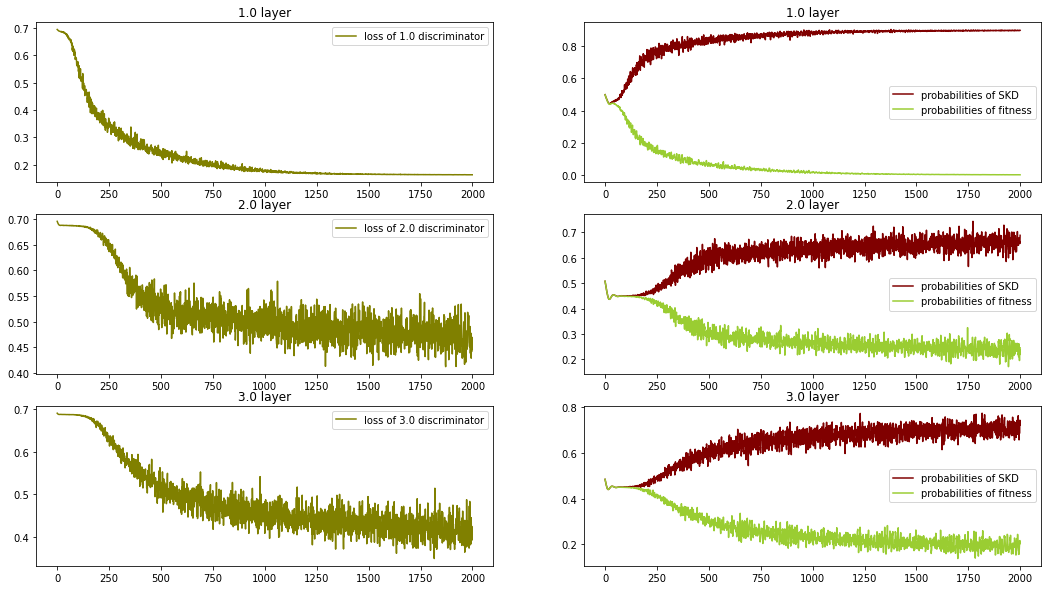

In [ ]:
plot_loss_probs(discrim_check_dict)

### 5. Learning rate annealing, protect NaN and Inf

In [ ]:
from math import isfinite

# If loss will be nan or inf
def protect(scalar):
    """Raise if a scalar is either NaN, or Inf."""
    if not isfinite(float(scalar)):
        raise FloatingPointError

    return scalar


def collate(records):
    """Turn list of dicts into dict of lists."""
    out = {}
    for record in records:
        for k, v in record.items():
            out.setdefault(k, []).append(v)

    *size, = map(len, out.values())
    assert all(size[0] == l for l in size)

    return out

For learning rate annealing

### 5. Actual Training for CNN with pseudo-generator loss

In [ ]:
model = SimpleConvNet(n_classes =10).cuda()

In [ ]:
# Define batch_size of convolutional filters for each layer
BATCH_CONVO_1 = 256
BATCH_CONVO_2 = 1024
BATCH_CONVO_3 = 1024

# Dictionary of batch_sizes of convolutional filters
batch_convo_filters = {"layer_1" :BATCH_CONVO_1, "layer_2" : BATCH_CONVO_2, "layer_3" : BATCH_CONVO_3}
# Dictionary ['layer_1','layer_2','layer_3'] of class' objects 
live_sampler_gen = {name: LiveConv2dSliceInfiniteSampler(module, batch_size = batch_convo_filters[name] ) 
                    for name, module in model.named_modules() if isinstance(module,torch.nn.Conv2d)}
# Dictionary ['layer_1','layer_2','layer_3'] of generators of each layer              
ker_iters_gen = {layer_name: iter(smplr) for layer_name, smplr in live_sampler_gen.items()}

## => batch_convo_filters , live_sampler_gen, ker_iters_gen

In [ ]:
# Define batch_size of SKD filters
# we are inclined to believe that BATCH_SKD = BATCH_CONVO
BATCH_SKD_1 = 256
BATCH_SKD_2 = 1024
BATCH_SKD_3 = 1024

batch_size_SKD = {"layer_1":BATCH_SKD_1, "layer_2" : BATCH_SKD_2, "layer_3" : BATCH_SKD_3}
train_loaders_SKD = {name: torch.utils.data.DataLoader(dataset=SKD_convolutional_weights[name].cuda(),batch_size=batch_size,shuffle=True)\
                        for name, batch_size in batch_size_SKD.items()}
## => train_loaders_SKD

In [ ]:
# define intermediate layers of Discriminator
HIDDEN_DISCR = [100, 100]

# Dictionary of discriminators
discriminators = torch.nn.ModuleDict({
    name: Discriminator(module.weight.shape[-2:].numel(), HIDDEN_DISCR)
    for name, module in model.named_modules()
    if isinstance(module, torch.nn.Conv2d)
}).cuda()

In [ ]:
LR_model = 1e-3
WEIGHT_DECAY = 1e-4
LR_discriminator = 1e-3

optimizer_generator = torch.optim.Adam(
    model.parameters(), lr=LR_model, weight_decay= WEIGHT_DECAY)

optimizer_discriminator = torch.optim.Adam(
    discriminators.parameters(), lr=LR_discriminator)

In [ ]:
# amount data for training
TRAIN_AMOUNT = 1000

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, \
                                                 transform=torchvision.transforms.ToTensor(), download=True)
train_dataset, ignore, val_dataset = torch.utils.data.random_split(train_val_dataset, \
                                                                    [TRAIN_AMOUNT, 40000 - TRAIN_AMOUNT , 10000])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# batch size for images of cifar10
BATCH_SIZE = 64

task_loaders = {
    'train': torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'test': torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False),
}

In [ ]:
BETA_1 = 1e-3
BETA_2 = 1e-3
BETA_3 = 1e-3

beta_dictionary = {'layer_1': BETA_1,'layer_2': BETA_2,'layer_3': BETA_3}

In [ ]:
batch_sizes = {
    'layer_1': 256, 
    'layer_2': 1024,   
    'layer_3': 1024,   
}

In [ ]:
NUM_EPOCHS = 100
GENERATOR_STEPS = 100
DISCRIMINATOR_STEPS = 100 # the number of batches per epoch for each discriminator. It seems that discriminator must be powerful
MAX_GEN_EPOCHS = 1     # flash training of the pseudo-generator  (10 + lrsched is too string)
MAX_GEN_DRAWS = 1      # (just use bigger batches) number of model's kernel draws to compute the confuion terms with

#### 5.1 Base code

In [ ]:
def plot_learning_curves(history):

  fig = plt.figure(figsize=(50, 30))

  plt.subplot(1,2,1)
  plt.plot(history['loss']['train'],color = 'indigo',label = 'full loss train')
  plt.plot(history['task_loss']['train'], color = 'tomato',label = 'task loss')
  plt.plot(history['pseudo_gen_loss']['train'] ,color= 'gold',label = 'pseudo gen loss')
  plt.plot(history['loss']['val'],color = 'limegreen',label = 'validation loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history['acc']['train'],color= 'midnightblue',label= 'train accuracy')
  plt.plot(history['acc']['val'],color = 'firebrick' ,label = 'validation accuracy')
  plt.legend()
  
  fig,ax = plt.subplots(3,1,figsize=(18,12))
  ax = ax.flatten()
  ax[0].plot(history['prob_true']['layer_1'],color='purple',label='SKD filters 1st layer')
  ax[0].plot(history['prob_fake']['layer_1'],color='salmon',label='fitness filters 1st layer')
  ax[0].axhline(0.5, color='blue')
  ax[0].set_ylim([0,1])
  ax[0].set_ylabel('probability')
  ax[0].set_xlabel('num iterations')
  ax[0].set_title('500 samples per train : Batch 256')
  ax[0].legend()

  ax[1].plot(history['prob_true']['layer_2'],color='purple',label='SKD filters 2nd layer')
  ax[1].plot(history['prob_fake']['layer_2'],color='salmon',label='fitness filters 2nd layer')
  ax[1].axhline(0.5, color='blue')
  ax[1].set_ylim([0,1])
  ax[1].set_ylabel('probability')
  ax[1].set_xlabel('num iterations')
  ax[1].set_title('500 samples per train : Batch 1024')
  ax[1].legend()

  ax[2].plot(history['prob_true']['layer_3'],color='purple',label='SKD filters 3rd layer')
  ax[2].plot(history['prob_fake']['layer_3'],color='salmon',label='fitness filters 3rd layer')
  ax[2].axhline(0.5, color='blue')
  ax[2].set_ylim([0,1])
  ax[2].set_ylabel('probability')
  ax[2].set_xlabel('num iterations')
  ax[2].set_title('500 samples per train : Batch 1024')
  ax[2].legend()

  plt.show()

In [ ]:
def train_CNN(num_epochs,
              max_gen_epochs,
              generator_steps,
              max_gen_draws,
              model,
              discriminators,
              task_loaders,
              beta_dictionary,
              optimizer_generator,
              optimizer_discriminator,
              discriminator_steps,
              ker_iters_gen):
  
  history = defaultdict(lambda: defaultdict(list))

  

  probas = {layer: [] for layer, dis in discriminators.items()}
  betas_history = {layer: [value] for layer, value in beta_dictionary.items()}
  

  accuracy_train = []
  accuracy_val = []

  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss   =    0
    train_acc =       0

    val_loss =        0
    val_acc  =        0 

    start_time = time.time()
    
    # training of model
    model.requires_grad_(True)
    for discriminator in discriminators.values():
      discriminator.requires_grad_(False)
 
    for generator_epoch in tqdm.tqdm(range(max_gen_epochs)):
      for num_batch,(batch_x,batch_y) in zip(range(max_gen_batches),task_loaders['train']):
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        optimizer_generator.zero_grad()

        loss_task = gen_loss_task(model, input=batch_x, target = batch_y.long())

        
        dis_terms = {
                (layer): gen_loss_dis(dis, fake=next(ker_iters_gen[layer]).view(-1,\
                                                                                   next(ker_iters_gen[layer]).shape[-1]*\
                                         next(ker_iters_gen[layer]).shape[-2] ))
                 for layer, dis in discriminators.items()
 
                 }
 
        value = loss_task + sum(
        beta_dictionary.get(layer) * term
        for layer, term in dis_terms.items())
        
        
        logits_train = model(batch_x)
        y_pred_train = logits_train.max(1)[1].detach().cpu().numpy()
        train_acc += np.mean(batch_y.cpu().numpy() == y_pred_train)

        train_loss += np.sum(value.detach().cpu().numpy())
        #task_loss += np.sum(loss_task.detach().cpu().numpy())
        #pseudo_gen_loss += np.sum(sum( beta_dictionary.get(layer,1)*term \
                                      #for (layer,i),term in dis_terms.items()).detach().cpu().numpy())
         

         
        protect(value).backward()
        optimizer_generator.step()
        
         
      
    train_loss /= len(task_loaders['train'])
    train_acc /= len(task_loaders['train'])
    #task_loss /= len(task_loaders['train'])
    #pseudo_gen_loss  /= len(task_loaders['train'])

    history['loss']['train'].append(train_loss)
    #history['task_loss']['train'].append(task_loss)
    #history['pseudo_gen_loss']['train'].append(pseudo_gen_loss)
    history['acc']['train'].append(train_acc)

    accuracy_train.append(train_acc)
 
    
    # training of discriminator
    
    model.requires_grad_(False)
    for discriminator in discriminators.values():
      discriminator.requires_grad_(True)

    for _ in tqdm.tqdm(range(discriminator_steps)):
      loss = {}
      for layer, dis in discriminators.items(): 
       
        real = next(iter(train_loaders_SKD[layer])).cuda()
        fake = next(ker_iters_dis[layer]).detach()

        if real.shape[0] < fake.shape[0]:
          fake = fake[:real.shape[0]]
        elif real.shape[0] > fake.shape[0]:
          real = real[:fake.shape[0]]


        loss[layer] = dis_loss(dis, real=real, fake=fake)

        history['prob_true'][layer].append(dis(real).detach().sigmoid().mean().cpu().numpy())
        history['prob_fake'][layer].append(dis(fake).detach().sigmoid().mean().cpu().numpy())
        
    value = sum(loss.values())
    optimizer_discriminator.zero_grad()
    protect(value).backward()
    optimizer_discriminator.step()

    
    with torch.no_grad():

      model.requires_grad_(False)

      for batch_x,batch_y in tqdm.tqdm(task_loaders['val']):
        batch_x,batch_y = batch_x.cuda(), batch_y.cuda()
        loss_ = gen_loss_task(model,input=batch_x,target = batch_y)

        val_loss += np.sum(loss_.detach().cpu().numpy())
        logits = model(batch_x)
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        val_acc += np.mean(batch_y.cpu().numpy() == y_pred)
        
      val_loss /= len(task_loaders['val'])
      val_acc /= len(task_loaders['val']) 
      history['loss']['val'].append(val_loss)
      history['acc']['val'].append(val_acc)
        
       
    
    accuracy_val.append(val_acc)


    
      
    
    

    clear_output()
        
    #print results after each epoch
    print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
    plot_learning_curves(history)
  return model, history

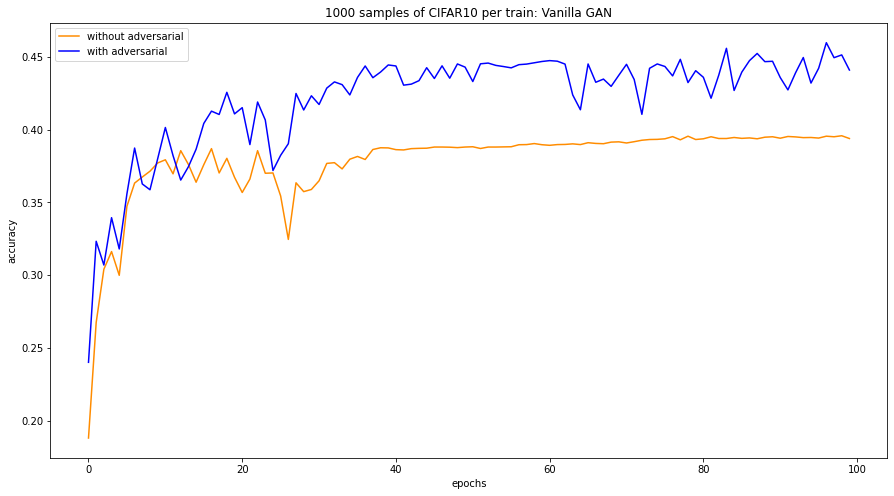

In [ ]:
model,history = train_CNN(NUM_EPOCHS,
                          MAX_GEN_EPOCHS,
              GENERATOR_STEPS,
              MAX_GEN_DRAWS,
              model,
              discriminators,
              task_loaders,
              beta_dictionary,
              optimizer_generator,
              optimizer_discriminator,
              DISCRIMINATOR_BATCHES,
              ker_iters_gen)